# Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

import csv

label2Name = {}
with open('./data/signnames.csv') as namesFile:
    nameReader = csv.reader(namesFile)
    for row in nameReader:
        label2Name[int(row[0])] = row[1]

# Step1: Dataset Summary & Exploration

## General numbers

In [2]:

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(list(y_train) + list(y_valid) + list(y_test)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


## Image samples

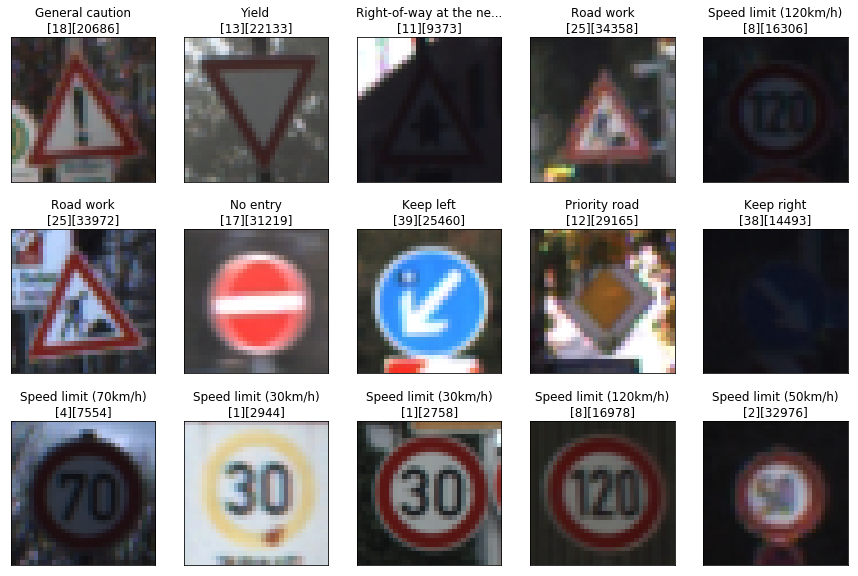

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def exploreData(images, labels, translation):
    """
    Visualize a random selection of images from `images`. 
    Showing the index and the label on the image title as:
    SIGNAL_NAME
    [label value][index value]
    """
    imgLength = len(images)
    assert(imgLength == len(labels))
    columns = 5
    rows = 3    
    imgW, imgH, _ = images[0].shape
    fig, axes = plt.subplots(rows, columns, figsize=(15,10),
                         subplot_kw={'xticks': [], 'yticks': []})
   
    indexes = list(random.randint(0, imgLength) for r in range(columns * rows))
    labelLimit = 25
    for ax, index in zip(axes.flat, indexes):
        ax.imshow(images[index])
        label = labels[index]
        name = translation[label]
        if len(name) > labelLimit - 3:
            name = name[:labelLimit - 3] + '...'
        ax.set_title("{1}\n[{2}][{0}]".format(index, name, label))


exploreData(X_train, y_train, label2Name)

## Label distribution

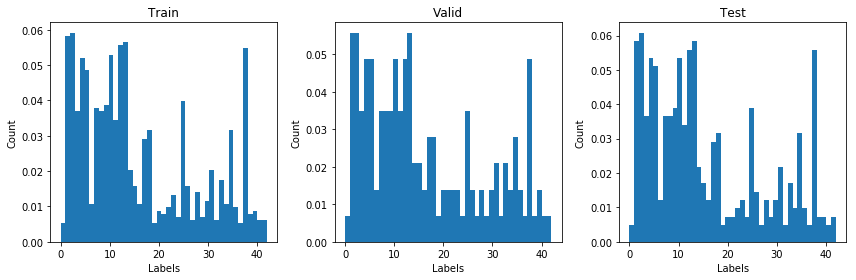

In [4]:
def plotLabelHistogram(labels, titles, numberOfLabels):
    """
    Plot the histogram of the list of `labels` using the `titles` as title for the graphs
    and the number of bins `numberOfLabels`.
    """
    nCols = len(labels)
    assert(nCols == len(titles))
    
    fig, axes = plt.subplots(ncols=nCols, figsize=(4*nCols, 4))
    for ax, label, title in zip(axes, labels, titles):        
        n, bins, patches = ax.hist(label, numberOfLabels, normed=1)
        ax.set_xlabel('Labels')
        ax.set_ylabel('Count')
        ax.set_title(title)
        
    fig.tight_layout()
    plt.show()
    
plotLabelHistogram([y_train, y_valid, y_test], ['Train', 'Valid', 'Test'], n_classes)

## Train image generation (augmentation)

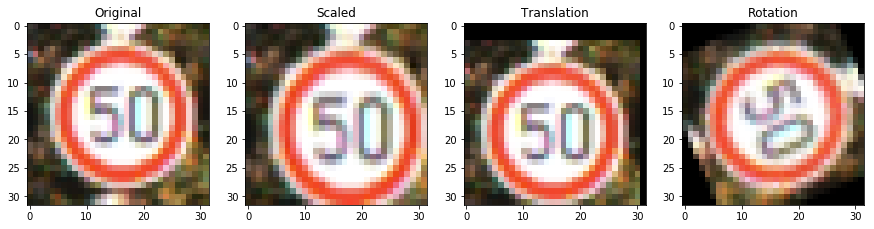

In [5]:
import cv2        
def transform(img, type = 0):
    if type == 0:
        fx = random.uniform(1.0, 1.3)
        fy = random.uniform(1.0, 1.3)
        return cv2.resize(img,None,fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)[0:32, 0:32,:]
    
    if type == 1: # Translation
        rY = random.randint(-5, 5)
        rX = random.randint(-5, 5)
        M = np.float32([[1,0,rY],[0,1,rX]])
    else:
        angle = random.randint(-90, 90)
        M = cv2.getRotationMatrix2D((16,16),angle,1)
    
    return cv2.warpAffine(img,M,(32,32))

fig, axes = plt.subplots(ncols=4, figsize=(15,10))
randomIndex = random.randint(0, len(X_train))
axes[0].imshow(X_train[randomIndex])
axes[0].set_title('Original')
axes[1].imshow(transform(X_train[randomIndex], 0))
axes[1].set_title('Scaled')
axes[2].imshow(transform(X_train[randomIndex], 1))
axes[2].set_title('Translation')
axes[3].imshow(transform(X_train[randomIndex], 2))
axes[3].set_title('Rotation')

New images count 61912


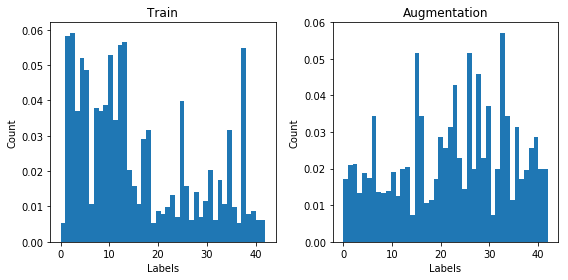

In [6]:

def generateImages(input, input_labels):
    hist, _ = np.histogram(input_labels, 43, normed=True)
    selectedLabel = []
    for index, v in enumerate(hist):
        if v < 0.02:
            selectedLabel.append(index)
    newInput = []
    newLabels = []
    for index, label in enumerate(input_labels):
        if label in selectedLabel:
            for i in range(0,8):
                type = random.randint(0, 3)
                newLabels.append(label)
                newInput.append(transform(input[index], type))
    
    return (np.array(newInput), np.array(newLabels))

X_train_new, y_train_new = generateImages(X_train, y_train)
print('New images count {}'.format(len(X_train_new)))
added = np.concatenate((y_train, y_train_new), axis=0)
plotLabelHistogram([y_train, added], ['Train', 'Augmentation'], n_classes)
X_train = np.concatenate((X_train, X_train_new), axis=0)
y_train = np.concatenate((y_train, y_train_new), axis=0)

# Step 2: Design and Test a Model Architecture

## Pre-processing

In [7]:
def preprocessing(images):
    output = np.zeros((len(images), 32, 32, 3), np.float64)
    for index, img in enumerate(images):
        gray = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
        output[index] = (gray.astype(np.float64) - 128)/128
    return output

In [8]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
X_train = preprocessing(X_train)
X_valid = preprocessing(X_valid)
X_test = preprocessing(X_test)

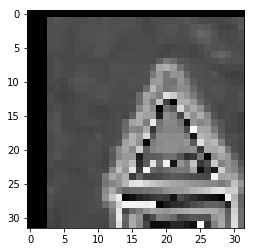

In [9]:
plt.imshow(X_train[1])

## Model Architecture

In [10]:
import tensorflow as tf

EPOCHS = 40
BATCH_SIZE = 128
modelLocation = './models/traffic_sign_model_1'
doTrain = True

In [11]:
from tensorflow.contrib.layers import flatten

def LeNet(x, mu = 0, sigma = 0.1): 
    """
    Defines the network. `x` as input. 
    `mu` and `sigma`: Arguments used for tf.truncated_normal, randomly defines variables for 
                      the weights and biases for each layer
    """
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
        
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.  6 => 16
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x16. Output = 14x14x16.  6 => 16
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x64.  Input 6 => 16  Output 16 => 64
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x64. Output = 5x5x64.  16 => 64
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x64. Output = 400.  16 => 64    400 => 1600
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1600. Output = 120. 400 => 1600  120 => 240
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 240), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(240))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b    
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.  120 => 240
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(240, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
                        
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return (logits, conv1, conv2, fc1, fc2)

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

## Train, Validate and Test the Model

In [13]:
rate = 0.001

logits, conv1, conv2, fc1, fc2 = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [14]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [15]:
epoch_validation = np.zeros((EPOCHS), dtype=np.float64)
test_accuracy = 0.0
if doTrain:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training...")
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})

            validation_accuracy = evaluate(X_valid, y_valid)
            epoch_validation[i] = validation_accuracy

        test_accuracy = evaluate(X_test, y_test)
        print('Training finished')
        saver.save(sess, modelLocation)
else:
    print('No training configured')

Training...
Training finished


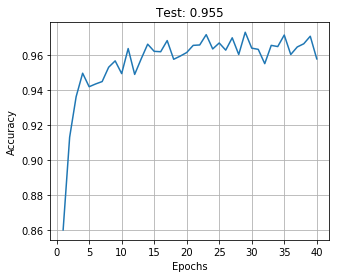

In [16]:
if doTrain:
    fig, axes = plt.subplots(ncols=1, figsize=(5, 4))
    axes.plot(range(1, EPOCHS + 1), epoch_validation)
    axes.set_xlabel('Epochs')
    axes.set_ylabel('Accuracy')
    axes.set_title('Test: {:.3f}'.format(test_accuracy))
    axes.grid(True)
else:
    print('No training configured')

# Step 3: Test a Model on New Images

## Load and Output the Images

In [17]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import glob
import matplotlib.image as mpimg

In [18]:
webImagesDir = 'webimages'
imageNames = glob.glob('webimages/*.jpg')
webImages = [ mpimg.imread('./' + imgName ) for imgName in imageNames ]


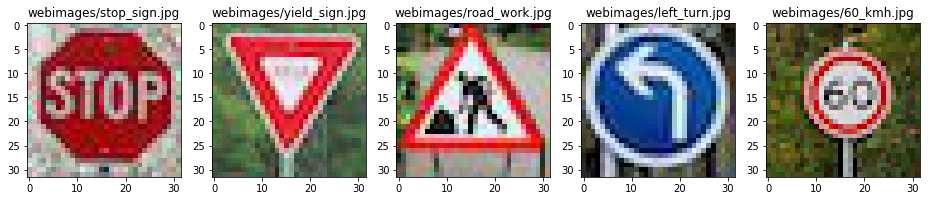

In [19]:
fig, axes = plt.subplots(ncols=len(webImages), figsize=(16, 8))
for ax, image, imageName in zip(axes, webImages, imageNames):
    ax.imshow(image)
    ax.set_title(imageName)

In [20]:
# Pre-processing
X_web = preprocessing(webImages)

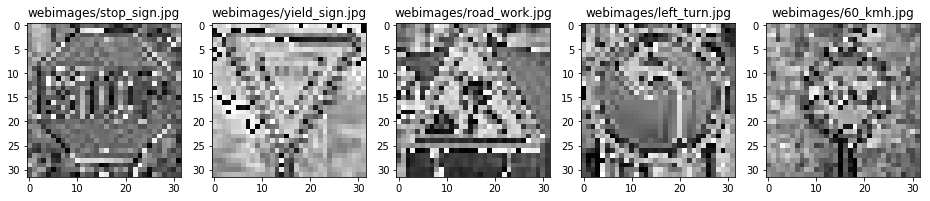

In [21]:
fig, axes = plt.subplots(ncols=len(webImages), figsize=(16, 8))
for ax, image, imageName in zip(axes, X_web, imageNames):
    ax.imshow(image)
    ax.set_title(imageName)

In [22]:
with tf.Session() as sess:
    saver.restore(sess, modelLocation)

    web_classes = sess.run(logits, feed_dict={x: X_web, keep_prob : 1.0})
    

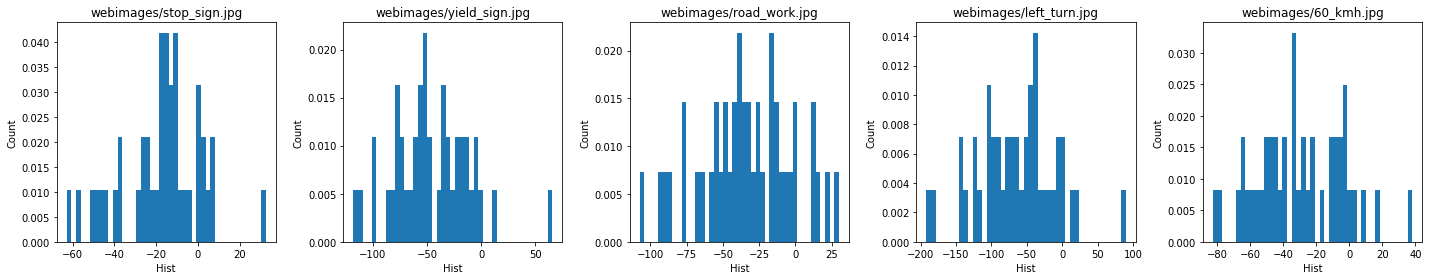

In [23]:
def plotSoftmaxHist(classes, names):
    """
    Plot the histogram for the network output
    """
    nCols = len(classes)
    assert(nCols == len(names))
    
    fig, axes = plt.subplots(ncols=nCols, figsize=(4*nCols, 4))
    for ax, aClass, title in zip(axes, classes, names):        
        n, bins, patches = ax.hist(aClass, 43, normed=1)
        ax.set_xlabel('Hist')
        ax.set_ylabel('Count')
        ax.set_title(title)
        
    fig.tight_layout()
    plt.show()

plotSoftmaxHist(web_classes, imageNames)

In [24]:
with tf.Session() as sess:
    predicts = sess.run(tf.nn.top_k(web_classes, k=5, sorted=True))

In [25]:
namedPredictions = [ label2Name[predicts[1][i][0]] for i in range(0, len(imageNames))]

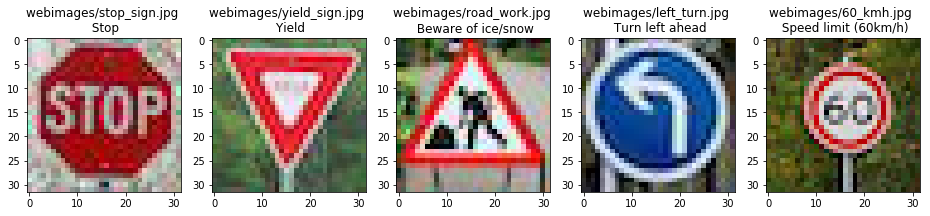

In [26]:
fig, axes = plt.subplots(ncols=len(webImages), figsize=(16, 8))
for ax, image, imageName, predictedName in zip(axes, webImages, imageNames, namedPredictions):
    index = predicts[1][1]
    ax.imshow(image)
    ax.set_title('{} \n {}'.format(imageName, predictedName))

#### One image wrong (webimages/road_work.jpg). 80% accuracy

## Top 5 softmax probabilities 

In [27]:
for i in range(len(predicts[0])):
    print('Image: ' + imageNames[i])
    print('Probabilities:')
    for j in range(0, len(predicts[0][i])):
        prob = predicts[0][i][j]
        index = predicts[1][i][j]
        name = label2Name[index]
        print('   {:.3f} : {} - {}'.format(prob, index, name))
    print()

Image: webimages/stop_sign.jpg
Probabilities:
   32.556 : 14 - Stop
   8.078 : 24 - Road narrows on the right
   6.619 : 29 - Bicycles crossing
   5.679 : 0 - Speed limit (20km/h)
   2.261 : 26 - Traffic signals

Image: webimages/yield_sign.jpg
Probabilities:
   65.943 : 13 - Yield
   11.349 : 29 - Bicycles crossing
   -0.900 : 35 - Ahead only
   -3.275 : 25 - Road work
   -6.000 : 34 - Turn left ahead

Image: webimages/road_work.jpg
Probabilities:
   29.975 : 30 - Beware of ice/snow
   22.087 : 24 - Road narrows on the right
   16.370 : 29 - Bicycles crossing
   13.887 : 23 - Slippery road
   11.258 : 21 - Double curve

Image: webimages/left_turn.jpg
Probabilities:
   89.443 : 34 - Turn left ahead
   18.121 : 29 - Bicycles crossing
   11.056 : 23 - Slippery road
   2.369 : 37 - Go straight or left
   -0.442 : 35 - Ahead only

Image: webimages/60_kmh.jpg
Probabilities:
   37.983 : 3 - Speed limit (60km/h)
   15.663 : 38 - Keep right
   9.374 : 9 - No passing
   2.040 : 23 - Slippery ro

# Step 4 (Optional): Visualize the Neural Network's State with Test Images

In [28]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    if featuremaps > 48:
        featuremaps = 48
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

conv1 : First layer


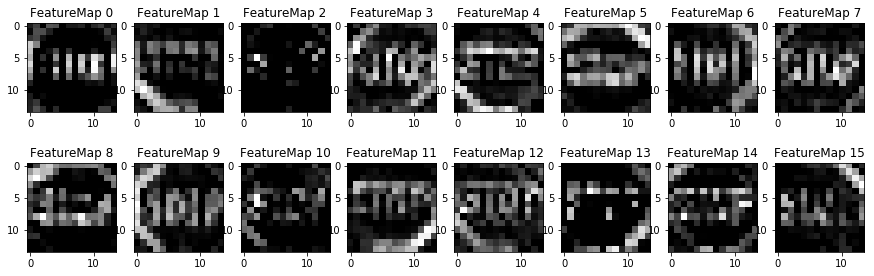

In [29]:
with tf.Session() as sess:
    saver.restore(sess, modelLocation)
    print("conv1 : First layer")
    outputFeatureMap(X_web, conv1)

conv2 : Second layer


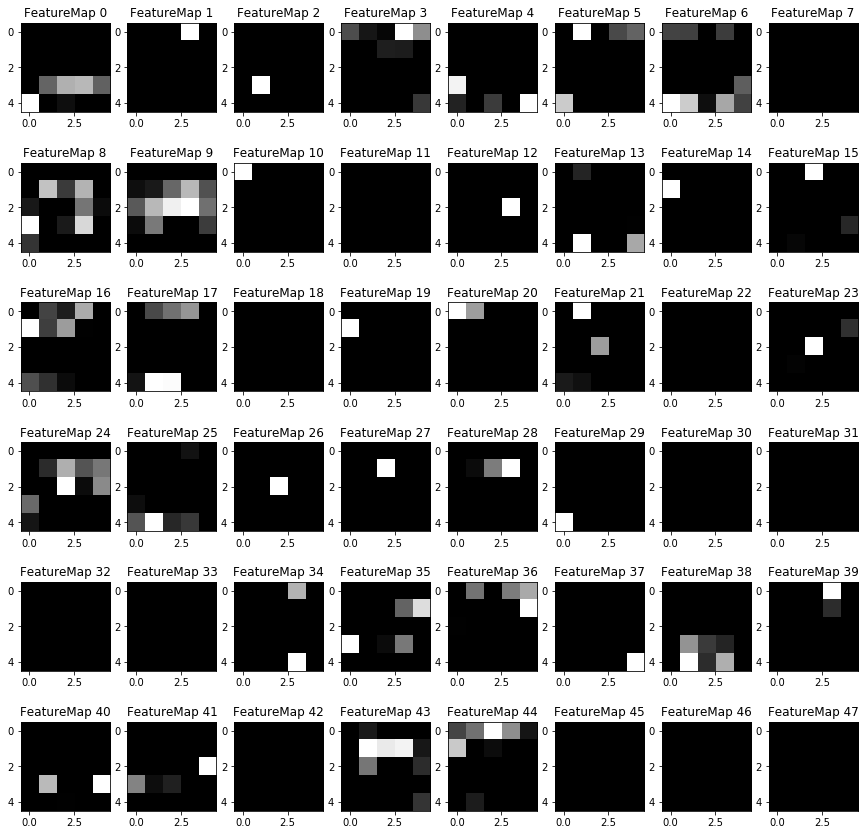

In [30]:
with tf.Session() as sess:
    saver.restore(sess, modelLocation)
    
    web_classes = sess.run(logits, feed_dict={x: X_web, keep_prob : 1.0})
    print("conv2 : Second layer")
    outputFeatureMap(X_web, conv2)